# Class Activation Learning
This is my implemetation of the Class Activation example from Lazy Programmer's Deep Learning: Advanced Computer Vision Udemy course.

The basic principle is that if, having classified an image, you follow the weighted paths back to the final convolution layer, you can multiply the weights for that classification by the output of the convolution layer to create a heatmap. This heatmap can then be scaled up to the size of the original image and overlaid. What that will show you is the rough areas in the input image that made the largest contribution to the final classification and localizes the classified object in the original image.

The trick here is to find a way to access both the activation data for the final convolution layer. The latter needs to be captured before max pooling / average pooling removes the spatial aspect of the data from the 7x7 feature kernels.

For this, I used the ResNet50 model that comes with Tensorflow as the starting point, trained for imagenet data. I then created a new Model instance that resuses the structure but captures both the normal, classification output, and the final Conv2D layer output which then provides what's needed to get at the class activation data.

To start with, import the libraries etc.

In [383]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json

# specific tensorflow imports
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

Create a complete ResNet50 model using imagenet weights from the Tensorflow applications library.

In [384]:
resnet = ResNet50(weights='imagenet')

Now find the two layers we want to get output from. The names were obtained by calling `resnet.summary()` and looking for the final, pre-average pooling layer and the final dense layer.

In [385]:
activation_layer = resnet.get_layer(name='conv5_block3_out')
final_dense = resnet.get_layer(name='predictions')

Now create a new `Model` instance from the resnet structure but with both of these layers specified as outputs. This will allow us to call `model.predict(x)` once and get both sets of values.

In [386]:
model = Model(inputs=resnet.inputs, outputs=[activation_layer.output, final_dense.output])

Create a dictionary of all of the classifications in the model so we can find the index of the predicted classification in the dense layer.

In [387]:
classifications = {
    key: (idx, value) 
    for (key, value, idx) in decode_predictions(np.expand_dims(np.arange(1000), 0), top=1000)[0][::-1]}

Load an image for test data.

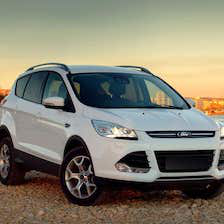

In [388]:
img = image.load_img('./test-images/224x224x3/car-1.jpeg', target_size=(224, 224))
img

Get the underlying array data from the image then add a new array dimension to it. This is done because the `model.predict(x)` takes a batch of images as its parameter and there's only one here. Finally, use the ResNet50 preprocess_input method to prep the data for prediction.

In [389]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

Perform the prediction and store the final Conv2D activations and the predictions.

In [390]:
acts, preds = model.predict(x)

1/1 [==============================] - 0s 419ms/step


Grab the highest scoring prediction.

In [391]:
predicted = np.array(decode_predictions(preds, top=1)).flatten()

print(predicted)

['n03770679' 'minivan' '0.78669935']


Find the index of the classification in the dense layer. We need to do this because we need to know the weights to the feature maps it uses to make this prediction.

In [392]:
class_index, class_name = classifications[predicted[0]]
print(class_index, class_name)

656 minivan


Get all of the output weights for the predicted classification. `weights[0]` are the input weights and `weights[1]` are the output weights.

In [398]:
weights = final_dense.get_weights()
pred_weights = np.array(weights[0])[:,class_index]

If we have a look at the activation data from the final feature map layer, you can see the activations for all 2048 7x7 feature maps. An example of the one at position 1024 is also shown below.

In [401]:
print(acts[0].shape)
print(acts[0,:,:,1024])

(7, 7, 2048)
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.5235424  0.2907281  0.         0.         0.
  0.        ]
 [0.12022007 0.9559486  0.93767357 0.31835485 0.         0.
  0.        ]
 [0.         0.9337647  1.3132763  0.         0.         0.
  0.        ]
 [0.         0.         0.7501343  0.         0.         0.
  0.        ]
 [0.         0.345052   1.6310549  0.         0.         0.
  0.        ]]


The heatmap is then created from the sum of the activation data multiplied by the weighting for the classification.
$$H=\sum_{i=0}^{n}(A_{i}W_{i})$$
This is also the dot product of the activations and the weights so the numpy [`dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) function can be used.
The output of the dot product is a 7x7 heatmap so in order to overlay it onto the original image it needs to be scaled to the same size as the original image which is 224 x 224 pixels. The SciPy [`ndimage.zoom()`](https://docs.scipy.org/doc//scipy-1.3.0/reference/generated/scipy.ndimage.zoom.html) method can do this.

In [396]:
heat = np.dot(acts[0], pred_weights)
heat = sp.ndimage.zoom(heat, (32, 32), order=1)
heat.shape

(224, 224)

Finally we can plot the two images in matplotlib.

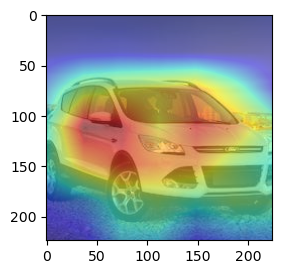

In [397]:
plt.subplot(1, 2, 1)
plt.imshow(img, alpha=0.8)
plt.imshow(heat, cmap='jet', alpha=0.5)
plt.show()